In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'


In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
                             RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score, roc_curve, classification_report
import classifier_utils as cu

In [30]:
data = pd.read_csv('data/cleaned_data_more_feats.csv', index_col = 0)

In [31]:
train_df, test_df = train_test_split(data, test_size = .25)
all_feats = data.columns[5:-3]
best_feats =['period','impact_parameter','transit_duration','transit_depth','radius','inclination',
             'mse_stat','mme_stat','signal_to_noise','num_transits','oedc_stat','stellar_eff_temp',
             'stellar_surf_grav','stellar_metal','stellar_radius','stellar_mass']

## Baseline model performance

In [32]:
model = xgb.XGBClassifier(n_estimators=50000,max_depth = 6,eta = 0.025,objective='binary:logistic',
                          min_child_weight=1,subsample = 1,colsample_bytree=.8,use_label_encoder=False)

In [33]:
cu.xgb_test_model_CV(model, train_df, best_feats)

Mean validation accuracy: 0.881
Mean validation recall  : 0.916
Mean validation precision: 0.861
Mean validation f1  : 0.888
Mean validation roc_auc: 0.943


                 precision    recall  f1-score   support

Not a Candidate       0.90      0.84      0.87       716
      Candidate       0.86      0.91      0.88       782

       accuracy                           0.88      1498
      macro avg       0.88      0.87      0.88      1498
   weighted avg       0.88      0.88      0.88      1498



<Figure size 900x600 with 0 Axes>

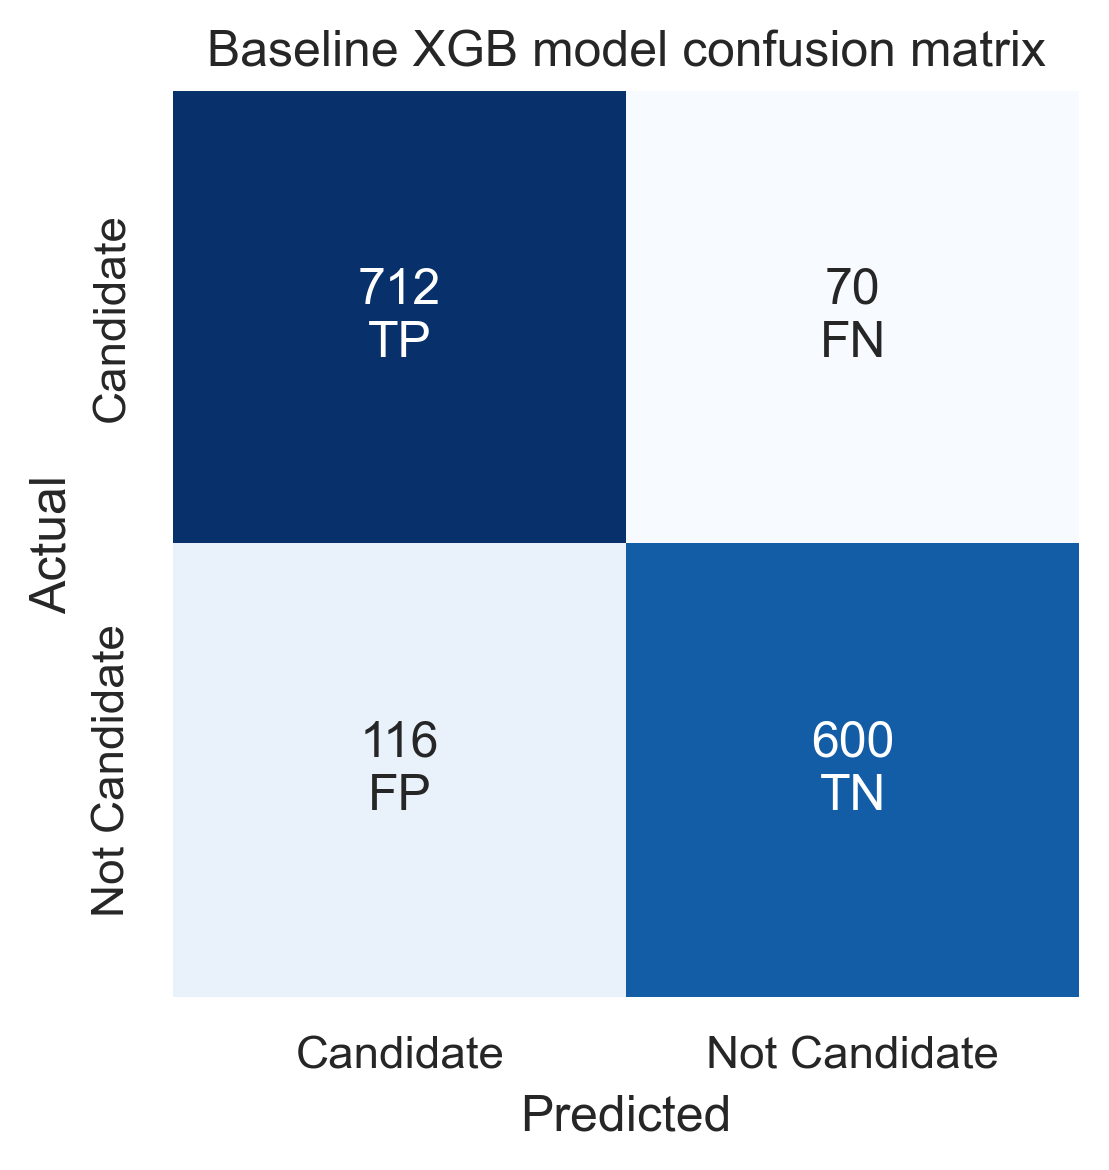

In [34]:
cu.plot_confusion_matrix(model, train_df, best_feats, title='Baseline XGB model')

ROC AUC score =  0.929672877166412


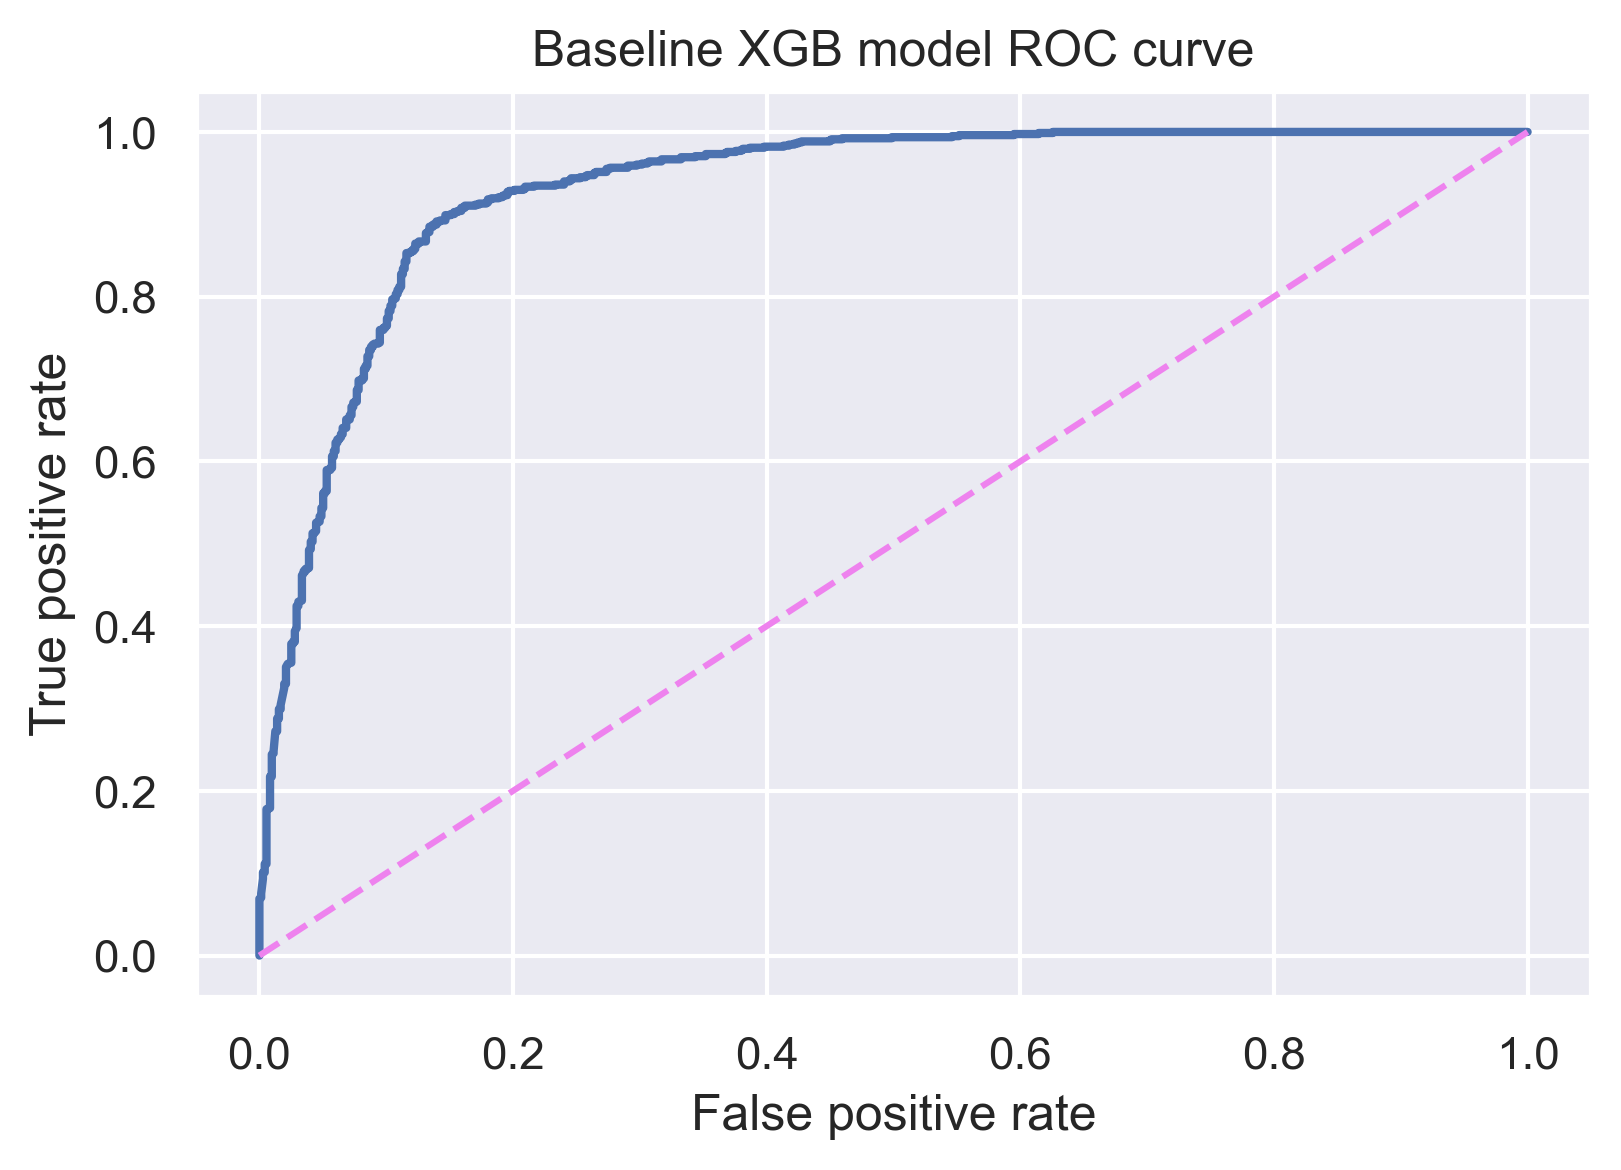

In [35]:
cu.plot_roc_curve(model, train_df, best_feats, title='Baseline XGB model')

In [42]:
 data

,id,koi_name,kepler_name,planet_status,data_disposition,period,impact_parameter,transit_duration,transit_depth,radius,sma,inclination,eq_temp,mse_stat,mme_stat,signal_to_noise,num_transits,oedc_stat,stellar_eff_temp,stellar_surf_grav,stellar_metal,stellar_radius,stellar_mass,ra,dec,disposition_num
rowid,,,,,,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,0.146,2.95750,616.0,2.26,0.0853,89.66,793.0,5.135849,28.470820,35.8,142.0,0.6864,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,0.586,4.50700,875.0,2.83,0.2734,89.57,443.0,7.027669,20.109507,25.8,25.0,0.0023,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1
3,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,19.899140,0.969,1.78220,10800.0,14.60,0.1419,88.96,638.0,37.159767,187.449100,76.3,56.0,0.6624,5853.0,4.544,-0.18,0.868,0.961,297.00482,48.134129,1
4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.736952,1.276,2.40641,8080.0,33.46,0.0267,67.09,1395.0,39.066550,541.895100,505.6,621.0,0.0000,5805.0,4.564,-0.52,0.791,0.836,285.53461,48.285210,0
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,0.701,1.65450,603.0,2.75,0.0374,85.41,1406.0,4.749945,33.191900,40.9,515.0,0.3090,6031.0,4.438,0.07,1.046,1.095,288.75488,48.226200,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.527699,1.252,3.22210,1580.0,29.35,0.0128,20.78,2088.0,21.335920,223.141400,453.3,2026.0,-1.0000,5638.0,4.529,0.14,0.903,1.005,297.18875,47.093819,0
9561,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,1.739849,0.043,3.11400,48.5,0.72,0.0290,89.42,1608.0,3.841146,8.569540,10.6,766.0,0.1374,6119.0,4.444,-0.04,1.031,1.075,286.50937,47.163219,1
9562,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.681402,0.147,0.86500,104.0,1.07,0.0157,88.60,2218.0,3.748643,9.653322,12.3,1969.0,0.9995,6173.0,4.447,-0.04,1.041,1.104,294.16489,47.176281,0


## Incorporating features based on error 

In [55]:
raw_data_with_err = pd.read_csv('data/kepler_data_with_err.csv', index_col = 0)

In [57]:
err_cols = list(raw_data_with_err.columns)
err_cols = [col for col in err_cols if '_err' in col]

In [60]:
err_df = raw_data_with_err[['koi_name']+err_cols]
err_df

,koi_name,period_err1,period_err2,impact_parameter_err1,impact_parameter_err2,transit_duration_err1,transit_duration_err2,transit_depth_err1,transit_depth_err2,radius_err1,radius_err2,stellar_eff_temp_err1,stellar_eff_temp_err2,stellar_surf_grav_err1,stellar_surf_grav_err2,stellar_metal_err1,stellar_metal_err2,stellar_radius_err1,stellar_radius_err2,stellar_mass_err1,stellar_mass_err2
rowid,,,,,,,,,,,,,,,,,,,,,
1,K00752.01,2.780000e-05,-2.780000e-05,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046
2,K00752.02,2.480000e-04,-2.480000e-04,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046
3,K00753.01,1.490000e-05,-1.490000e-05,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0,0.044,-0.176,0.30,-0.30,0.233,-0.078,0.110,-0.121
4,K00754.01,2.630000e-07,-2.630000e-07,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0,0.053,-0.168,0.30,-0.30,0.201,-0.067,0.093,-0.077
5,K00755.01,3.760000e-06,-3.760000e-06,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0,0.070,-0.210,0.25,-0.30,0.334,-0.133,0.151,-0.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,K07985.01,1.160000e-07,-1.160000e-07,0.051,-0.049,0.01740,-0.01740,4.6,-4.6,7.70,-2.57,139.0,-166.0,0.035,-0.196,0.20,-0.30,0.237,-0.079,0.084,-0.115
9561,K07986.01,1.780000e-05,-1.780000e-05,0.423,-0.043,0.22900,-0.22900,5.4,-5.4,0.24,-0.08,165.0,-220.0,0.056,-0.224,0.25,-0.30,0.341,-0.114,0.151,-0.135
9562,K07987.01,2.430000e-06,-2.430000e-06,0.309,-0.147,0.16200,-0.16200,14.7,-14.7,0.36,-0.11,193.0,-236.0,0.056,-0.224,0.25,-0.35,0.341,-0.114,0.146,-0.162


In [71]:
data_with_err = data.merge(err_df, how='left', on = 'koi_name')\
                    .dropna(axis=0, subset = err_cols)

In [78]:
cols_with_errs = [col[:-5] for col in err_cols[::2]]
for col in cols_with_errs:
    data_with_err[col + '_err_size'] = data_with_err[col + '_err1']-data_with_err[col + '_err2']
    data_with_err[col + '_err_proportion'] = data_with_err[col + '_err_size']/data_with_err[col]

In [79]:
data_with_err

,id,koi_name,kepler_name,planet_status,data_disposition,period,impact_parameter,transit_duration,transit_depth,radius,sma,inclination,eq_temp,mse_stat,mme_stat,signal_to_noise,num_transits,oedc_stat,stellar_eff_temp,stellar_surf_grav,stellar_metal,stellar_radius,stellar_mass,ra,dec,disposition_num,period_err1,period_err2,impact_parameter_err1,impact_parameter_err2,transit_duration_err1,transit_duration_err2,transit_depth_err1,transit_depth_err2,radius_err1,radius_err2,stellar_eff_temp_err1,stellar_eff_temp_err2,stellar_surf_grav_err1,stellar_surf_grav_err2,stellar_metal_err1,stellar_metal_err2,stellar_radius_err1,stellar_radius_err2,stellar_mass_err1,stellar_mass_err2,period_err_size,period_err_proportion,impact_parameter_err_size,impact_parameter_err_proportion,transit_duration_err_size,transit_duration_err_proportion,transit_depth_err_size,transit_depth_err_proportion,radius_err_size,radius_err_proportion,stellar_eff_temp_err_size,stellar_eff_temp_err_proportion,stellar_surf_grav_err_size,stellar_surf_grav_err_proportion,stellar_metal_err_size,stellar_metal_err_proportion,stellar_radius_err_size,stellar_radius_err_proportion,stellar_mass_err_size,stellar_mass_err_proportion
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,9.488036,0.146,2.95750,616.0,2.26,0.0853,89.66,793.0,5.135849,28.470820,35.8,142.0,0.6864,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1,2.780000e-05,-2.780000e-05,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046,5.560000e-05,5.860012e-06,0.464,3.178082,0.16380,0.055385,39.0,0.063312,0.41,0.181416,162.0,0.029698,0.160,0.035818,0.30,2.142857,0.166,0.179072,0.098,0.106638
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,54.418383,0.586,4.50700,875.0,2.83,0.2734,89.57,443.0,7.027669,20.109507,25.8,25.0,0.0023,5455.0,4.467,0.14,0.927,0.919,291.93423,48.141651,1,2.480000e-04,-2.480000e-04,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0,0.064,-0.096,0.15,-0.15,0.105,-0.061,0.052,-0.046,4.960000e-04,9.114567e-06,0.502,0.856655,0.23200,0.051475,71.0,0.081143,0.51,0.180212,162.0,0.029698,0.160,0.035818,0.30,2.142857,0.166,0.179072,0.098,0.106638
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,19.899140,0.969,1.78220,10800.0,14.60,0.1419,88.96,638.0,37.159767,187.449100,76.3,56.0,0.6624,5853.0,4.544,-0.18,0.868,0.961,297.00482,48.134129,1,1.490000e-05,-1.490000e-05,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0,0.044,-0.176,0.30,-0.30,0.233,-0.078,0.110,-0.121,2.980000e-05,1.497552e-06,5.203,5.369453,0.06820,0.038267,342.0,0.031667,5.23,0.358219,334.0,0.057065,0.220,0.048415,0.60,-3.333333,0.311,0.358295,0.231,0.240375
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.736952,1.276,2.40641,8080.0,33.46,0.0267,67.09,1395.0,39.066550,541.895100,505.6,621.0,0.0000,5805.0,4.564,-0.52,0.791,0.836,285.53461,48.285210,0,2.630000e-07,-2.630000e-07,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0,0.053,-0.168,0.30,-0.30,0.201,-0.067,0.093,-0.077,5.260000e-07,3.028292e-07,0.207,0.162226,0.01074,0.004463,25.6,0.003168,11.33,0.338613,331.0,0.057020,0.221,0.048422,0.60,-1.153846,0.268,0.338812,0.170,0.203349
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,2.525592,0.701,1.65450,603.0,2.75,0.0374,85.41,1406.0,4.749945,33.191900,40.9,515.0,0.3090,6031.0,4.438,0.07,1.046,1.095,288.75488,48.226200,1,3.760000e-06,-3.760000e-06,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0,0.070,-0.210,0.25,-0.30,0.334,-0.133,0.151,-0.136,7.520000e-06,2.977520e-06,0.713,1.017118,0.08400,0.050771,33.8,0.056053,1.23,0.447273,380.0,0.063008,0.280,0.063091,0.55,7.857143,0.467,0.446463,0.287,0.262100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7984,10090151,K07985.01,NaN,FALSE POSIT

In [86]:
train_df, test_df = train_test_split(data_with_err, test_size = .25)

In [83]:
err_sizes = [col for col in list(data_with_err.columns) if '_err_size' in col]
err_proportions = [col for col in list(data_with_err.columns) if '_err_proportion' in col]

In [87]:
cu.xgb_test_model_CV(model, train_df, best_feats)

Mean validation accuracy: 0.885
Mean validation recall  : 0.915
Mean validation precision: 0.870
Mean validation f1  : 0.892
Mean validation roc_auc: 0.949


In [88]:
cu.xgb_test_model_CV(model, train_df, best_feats+err_sizes)

Mean validation accuracy: 0.888
Mean validation recall  : 0.912
Mean validation precision: 0.877
Mean validation f1  : 0.894
Mean validation roc_auc: 0.951


In [89]:
cu.xgb_test_model_CV(model, train_df, best_feats+err_proportions)

Mean validation accuracy: 0.890
Mean validation recall  : 0.914
Mean validation precision: 0.879
Mean validation f1  : 0.896
Mean validation roc_auc: 0.954
